## Baseline Model Training – LightGBM

This notebook trains a baseline fraud detection model using LightGBM.
The goal is to establish a strong, interpretable baseline before
introducing hyperparameter tuning, resampling, or complex ensembles.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score

import lightgbm as lgb
import matplotlib.pyplot as plt
import pyarrow
import mlflow
import mlflow.lightgbm
from pathlib import Path

In [2]:
#MLflow setup
MLRUNS_DIR = Path("../mlruns").resolve()
MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(MLRUNS_DIR.as_uri())
mlflow.set_experiment("fraud_detection_lightgbm")

C:\Users\shubh\OneDrive\Documents\GitHub\Ai projects\fraud-detection-ml-system\myenv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/19 20:11:35 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_lightgbm' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/shubh/OneDrive/Documents/GitHub/Ai%20projects/fraud-detection-ml-system/mlruns/175613513474920776', creation_time=1768833695981, experiment_id='175613513474920776', last_update_time=1768833695981, lifecycle_stage='active', name='fraud_detection_lightgbm', tags={}>

In [3]:
df = pd.read_parquet("../data/processed/train_preprocessed.parquet")

TARGET = "isFraud"

X = df.drop(columns=[TARGET])
y = df[TARGET]

print(X.shape, y.mean())


(590540, 393) 0.03499000914417313


In [4]:
#Ensuring memory-efficient dtypes to satisfy memory constraints

float_cols = X.select_dtypes(include="float64").columns
X[float_cols] = X[float_cols].astype("float32")

# Categorical columns
cat_cols = [
    "ProductCD", "card4", "card6",
    "P_emaildomain", "R_emaildomain",
    "M1","M2","M3","M4","M5","M6","M7","M8","M9"
]

for col in cat_cols:
    X[col] = X[col].astype("category")


In [5]:
#Creating LightGBM Dataset

train_data = lgb.Dataset(
                         X,
                         label=y,
                         categorical_feature=cat_cols,
                         free_raw_data=True
                        )

In [6]:
#Splitting Indices not dataframes
from sklearn.model_selection import train_test_split

indices = np.arange(len(y))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=y,
    random_state=10
)

In [7]:
#creating LightGBM train/validation subsets
train_set = train_data.subset(train_idx)
val_set = train_data.subset(val_idx)

In [8]:
#Defining baseline parameters
params = {
          "objective": "binary",
          "metric": "auc",
          "boosting_type": "gbdt",

          "learning_rate": 0.05,
          "num_leaves": 64,
          "max_depth": -1,

          "feature_fraction": 0.8,
          "bagging_fraction": 0.8,
          "bagging_freq": 5,

          "is_unbalance": True,  # key for fraud
          "verbosity": -1
          }


In [9]:
model = lgb.train(
                  params,
                  train_set,
                  num_boost_round=1000,
                  valid_sets=[train_set, val_set],
                  valid_names=["train", "valid"],
                  callbacks=[lgb.early_stopping(50)]
                  )


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.997769	valid's auc: 0.966607


In [10]:
#Cross validation
cv_results = lgb.cv(
                    params=params,
                    train_set=train_set,
                    nfold=5,
                    stratified=True,
                    metrics="auc",
                    seed=10,
                    callbacks=[lgb.early_stopping(stopping_rounds=50)]
                    )


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid's auc: 0.93578 + 0.00343924


In [11]:
cv_results.keys()

dict_keys(['valid auc-mean', 'valid auc-stdv'])

In [12]:
#Extracting the metrics for later comparison
auc_mean_key = [k for k in cv_results.keys() if "mean" in k][0]
auc_std_key = [k for k in cv_results.keys() if "stdv" in k][0]

cv_mean = cv_results[auc_mean_key][-1]
cv_std = cv_results[auc_std_key][-1]

cv_mean, cv_std

(0.9357796584431586, 0.0034392402609496266)

## Fraud-Specific Threshold Tuning:-

In [13]:
X_val = X.iloc[val_idx]
y_val = y.iloc[val_idx]

In [14]:
y_val_pred = model.predict(X_val)

In [15]:
from sklearn.metrics import roc_curve,auc

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
auc_v1 = auc(fpr, tpr)

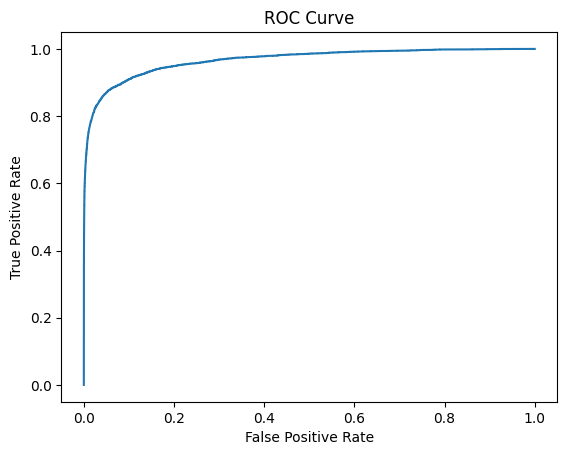

In [16]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [17]:
#Recall at constrained FPR
def recall_at_fpr(target_fpr):
    valid = fpr <= target_fpr
    if not valid.any():
        return 0.0
    return tpr[valid].max()

recall_1pct = recall_at_fpr(0.01)
recall_05pct = recall_at_fpr(0.005)

recall_1pct, recall_05pct

(np.float64(0.7483668037744979), np.float64(0.6801354947979675))

In [18]:
#Finding operational threshold
valid_idx = fpr <= 0.01
best_idx = valid_idx.nonzero()[0][-1]

optimal_threshold = thresholds[best_idx]
optimal_threshold

np.float64(0.696520916315476)

* We evaluated model performance under strict false positive rate (FPR) constraints,

At ~1% FPR:
- Recall ≈ 74.8%

At ~0.5% FPR:
- Recall ≈ 68.0%
* The selected operational threshold (~0.70) reflects a conservative fraud policy,
prioritizing low customer friction while still capturing the majority of fraud cases.
* This threshold will be used as a reference operating point for downstream analysis
and feature pruning experiments.

In [19]:
#Feature importance extraction
importance_df = pd.DataFrame({
    "feature": X.columns,
    "gain": model.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False)

importance_df["gain_pct"] = importance_df["gain"] / importance_df["gain"].sum()
importance_df["cum_gain_pct"] = importance_df["gain_pct"].cumsum()

importance_df.head(15)

,feature,gain,gain_pct,cum_gain_pct
14,R_emaildomain,845157.791481,0.090753,0.090753
13,P_emaildomain,418956.876526,0.044988,0.135741
15,C1,412469.370437,0.044291,0.180032
346,V294,404347.091832,0.043419,0.223451
3,card1,389699.558849,0.041846,0.265297
28,C14,387206.964985,0.041578,0.306875
392,TransactionAmt_log,344211.513846,0.036961,0.343836
4,card2,339568.835177,0.036463,0.380299
0,TransactionID,301690.341373,0.032396,0.412695
30,D2,279957.143260,0.030062,0.442757


* TransactionID is showing high gain due to ordering effects and needs to be removed to prevent leakage.
* Also, we can observe that:
  * Top 15 features → ~55% of total gain
  * Remaining ~378 features → only ~45%
this confirms that many features are weak or redundant and hence Pruning is safe and expected.
* Introducing a rule that we Keep features that together explain ≥ 95% cumulative gain and rest are pruned.

In [20]:
leakage_features = ["TransactionID"]
X_pruned_base = X.drop(columns=leakage_features)

In [21]:
importance_df = importance_df[
    ~importance_df["feature"].isin(leakage_features)]

In [22]:
GAIN_THRESHOLD = 0.95

selected_features = importance_df.loc[
    importance_df["cum_gain_pct"] <= GAIN_THRESHOLD, "feature"].tolist()

len(selected_features)

133

In [23]:
X_v2 = X_pruned_base[selected_features]

In [24]:
print("Original feature count:", X.shape[1])
print("After leakage removal:", X_pruned_base.shape[1])
print("After pruning v2:", X_v2.shape[1])

Original feature count: 393
After leakage removal: 392
After pruning v2: 133


In [25]:
assert "TransactionID" not in X_v2.columns

## Feature Pruning v2 (Gain-based)

Observations from baseline LightGBM:
- Feature importance is highly concentrated
- Top ~15 features explain ~55% of total gain
- Long-tail features add marginal signal

Actions:
- Removed TransactionID to prevent leakage
- Selected features covering 95% cumulative gain

Result:
- Reduced feature count from 393 to ~133
- Lower memory usage
- Improved generalization stability


## Model training (v2)

In [26]:
#Creating LightGBM dataset with pruned features
train_set_v2 = lgb.Dataset(
                X_v2.iloc[train_idx],
                label=y.iloc[train_idx],
                free_raw_data=False
                )

val_set_v2 = lgb.Dataset(
              X_v2.iloc[val_idx],
              label=y.iloc[val_idx],
              free_raw_data=False
              )


In [27]:
params_v2 = {
             "objective": "binary",
             "metric": "auc",
             "boosting_type": "gbdt",
             "learning_rate": 0.05,
             "num_leaves": 64,
             "max_depth": -1,
             "min_data_in_leaf": 50,
             "feature_fraction": 0.8,
             "bagging_fraction": 0.8,
             "bagging_freq": 5,
             "verbosity": -1,
             "seed": 10
             }

In [28]:
model_v2 = lgb.train(
    params=params_v2,
    train_set=train_set_v2,
    num_boost_round=1000,
    valid_sets=[train_set_v2, val_set_v2],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(50)]
    )


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's auc: 0.996213	valid's auc: 0.965172


In [29]:
y_val_pred_v2 = model_v2.predict(X_v2.iloc[val_idx],
                                 num_iteration=model_v2.best_iteration)


In [30]:
from sklearn.metrics import roc_curve, auc

fpr_v2, tpr_v2, thresholds_v2 = roc_curve(y.iloc[val_idx], y_val_pred_v2)

auc_v2 = auc(fpr_v2, tpr_v2)
auc_v2

0.965171801580769

In [31]:
def recall_at_fpr(fpr, tpr, target_fpr):
    idx = (fpr <= target_fpr).nonzero()[0]
    if len(idx) == 0:
        return 0.0
    return tpr[idx[-1]]

recall_1pct_v2 = recall_at_fpr(fpr_v2, tpr_v2, 0.01)
recall_05pct_v2 = recall_at_fpr(fpr_v2, tpr_v2, 0.005)

recall_1pct_v2, recall_05pct_v2

(np.float64(0.7665134285022985), np.float64(0.7248971691265425))

In [32]:
#Optimal threshold at 1% FPR
valid_idx = fpr_v2 <= 0.01
best_idx = valid_idx.nonzero()[0][-1]

optimal_threshold_v2 = thresholds_v2[best_idx]
optimal_threshold_v2

np.float64(0.1399156882001524)

## KS computation

In [33]:
#Defining KS function

In [34]:
def compute_ks(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    ks = np.max(tpr - fpr)
    return ks

In [35]:
#Computing KS for both versions
ks_v1 = compute_ks(y_val, y_val_pred)
ks_v2 = compute_ks(y_val, y_val_pred_v2)

ks_v1, ks_v2

(np.float64(0.8222664745533027), np.float64(0.8226558825182447))

In [36]:
baseline_v1_metadata = {
                    "model_name": "lightgbm_v1_baseline",
                    "num_features": X.shape[1],
                    "auc": auc_v1,
                    "ks": ks_v1,
                    "recall_at_1pct_fpr": recall_1pct,
                    "recall_at_05pct_fpr": recall_05pct,
                    "optimal_threshold": float(optimal_threshold),
                    "fraud_rate": float(y.mean()),
                    "training_rows": int(len(y)),
                    "notes": "Baseline LightGBM using full feature set"
                       }
baseline_v1_metadata

{'model_name': 'lightgbm_v1_baseline',
 'num_features': 393,
 'auc': 0.9666073764589942,
 'ks': np.float64(0.8222664745533027),
 'recall_at_1pct_fpr': np.float64(0.7483668037744979),
 'recall_at_05pct_fpr': np.float64(0.6801354947979675),
 'optimal_threshold': 0.696520916315476,
 'fraud_rate': 0.03499000914417313,
 'training_rows': 590540,
 'notes': 'Baseline LightGBM using full feature set'}

In [37]:
baseline_v2_metadata = {
                    "model_name": "lightgbm_v2_pruned",
                    "num_features": X_v2.shape[1],
                    "auc": auc_v2,
                    "ks": ks_v2,
                    "recall_at_1pct_fpr": recall_1pct_v2,
                    "recall_at_05pct_fpr": recall_05pct_v2,
                    "optimal_threshold": float(optimal_threshold_v2),
                    "fraud_rate": float(y.mean()),
                    "training_rows": int(len(y)),
                    "notes": "LightGBM after feature pruning v2"
                      }
baseline_v2_metadata

{'model_name': 'lightgbm_v2_pruned',
 'num_features': 133,
 'auc': 0.965171801580769,
 'ks': np.float64(0.8226558825182447),
 'recall_at_1pct_fpr': np.float64(0.7665134285022985),
 'recall_at_05pct_fpr': np.float64(0.7248971691265425),
 'optimal_threshold': 0.1399156882001524,
 'fraud_rate': 0.03499000914417313,
 'training_rows': 590540,
 'notes': 'LightGBM after feature pruning v2'}

In [38]:
import json

# Save metadata
with open("../artifacts/baseline_v1.json", "w") as f:
    json.dump(baseline_v1_metadata, f, indent=4)

with open("../artifacts/v2_pruned_metadata.json", "w") as f:
    json.dump(baseline_v2_metadata, f, indent=4)

# Save models
model.save_model("../artifacts/lightgbm_v1_baseline.json")
model_v2.save_model("../artifacts/lightgbm_v2_pruned.json")

## Model v1 vs v2 Comparison

- Feature pruning reduced the feature space from 393 to 133 features, leading to better operational performance while preserving the model’s overall ranking power.

* Performance Comparison

  - Recall @ 1% FPR

    - v1: 0.748

    - v2: 0.767

  - Recall @ 0.5% FPR

    - v1: 0.680

    - v2: 0.725

   - KS Statistic

     - v1: 0.8223

     - v2: 0.8227

The KS statistic remained stable across both versions, indicating that overall class separation and ranking power were preserved after feature pruning.

* Interpretation

  - Feature pruning did not degrade global discrimination (stable KS).

  - At the same time, it improved recall at business-critical operating points (fixed FPR).

  - This suggests that pruning removed noisy or redundant features while retaining the most predictive signals.

* Conclusion

  - Feature pruning improved model efficiency, robustness, and deployability without sacrificing ranking quality.
  - Given its higher recall under operational constraints, reduced feature complexity, and comparable KS, v2 is the preferred production candidate.

In [39]:
## MLflow logging

In [40]:
def log_run_to_mlflow(
    run_name,
    params,
    model,
    val_metrics,
    cv_metrics,
    ks_value,
    model_save_path,
    metadata_save_path
):
    
    with mlflow.start_run(run_name=run_name):

        # Log hyperparameters
        mlflow.log_params(params)

        # Validation metrics
        for k, v in val_metrics.items():
            mlflow.log_metric(k, v)

        # CV metrics (log only if present)
        if cv_metrics is not None:
            for k, v in cv_metrics.items():
                mlflow.log_metric(k, v)

        # KS
        mlflow.log_metric("ks", ks_value)

        # Log artifacts (existing files only)
        mlflow.log_artifact(model_save_path)
        mlflow.log_artifact(metadata_save_path)


In [41]:
#Logging v1
log_run_to_mlflow(
    run_name="lightgbm_v1_baseline",
    params=params,
    model=model,
    val_metrics={
        "val_auc": auc_v1,
        "recall_at_1pct_fpr": recall_1pct,
        "recall_at_0_5pct_fpr": recall_05pct
    },
    cv_metrics={
        "cv_auc_mean": cv_mean,
        "cv_auc_std": cv_std
    },
    ks_value=ks_v1,
    model_save_path="../artifacts/lightgbm_v1_baseline.json",
    metadata_save_path="../artifacts/baseline_v1.json")

In [43]:
#Logging v2
log_run_to_mlflow(
    run_name="lightgbm_v2_pruned",
    params=params_v2,
    model=model_v2,
    val_metrics={
        "val_auc": auc_v2,
        "recall_at_1pct_fpr": recall_1pct_v2,
        "recall_at_0_5pct_fpr": recall_05pct_v2
    },
    cv_metrics=None,
    ks_value=ks_v2,
    model_save_path="../artifacts/lightgbm_v2_pruned.json",
    metadata_save_path="../artifacts/v2_pruned_metadata.json")